In [1]:
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import sys
import os
import seaborn as sns
import pandas as pd
import mpmath as mp
from scipy.optimize import fsolve

import mwc_induction_utils as mwc
mwc.set_plotting_style()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

colors=sns.color_palette('colorblind').as_hex()
colors[4] = sns.xkcd_palette(['dusty purple']).as_hex()[0]
sns.set_palette(colors)

colors_seq = sns.color_palette('viridis')

### Summation Strategy

The purpose of this notebook is to examine our model's predictions for titration curves in which multiple promoters are present. We begin with the example of the occupancy of identical promoters with multiplicity N, using summations. This follows the method from Brewster *et al* 2013, The Transcription Factor Titration Effect Dictates Level of Gene Expression.  

In [2]:
def fold_change(IPTG, K_A, K_I, e_AI, R, Op):
    '''
    Computes fold-change for simple repression
    Parameters
    ----------
    IPTG : array-like
        Array of IPTG concentrations in uM
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    R : float
        Number of repressors per cell
    Op : float
        Operator binding energy
    Returns
    -------
    probability that repressor is active
    '''
    return 1 / (1 + R / 4.6E6 * pact(IPTG, K_A, K_I, e_AI) * np.exp(-Op))

In [3]:
# Now define fold change function for variable N

# First need p_active
def pact(IPTG, K_A, K_I, e_AI):
    '''
    Computes the probability that a repressor is active
    Parameters
    ----------
    IPTG : array-like
        Array of IPTG concentrations in uM
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    Returns
    -------
    probability that repressor is active
    '''
    pact = (1 + IPTG * 1 / K_A)**2 / \
    (((1 + IPTG * 1 / K_A))**2 + np.exp(-e_AI) * (1 + IPTG * 1 / K_I)**2)
    return pact

def fold_change_var_N(IPTG, K_A, K_I, R, e_AI, N, Op):
    '''
    Computes the fold-change for N >= 1
    Parameters
    ----------
    R : float
        Number of repressors per cell
    e_AI : float
        Energetic difference between the active and inactive state
    N : float
        Number of operators available for repressor binding
    Op : float
        Binding energy between operator and repressor as inferred in Garcia 2011
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    Returns
    -------
    fold-change
    '''

    NNS = 4.6E6    #Number of nonspecific sites
    fc = []      #This will be my fold-change array
    
    for c in IPTG:
        pA = pact(c, K_A, K_I, e_AI)    #probability that a given repressor is active
        Reff = R * pA

        t = 0
        b = 0
        for m in range(0, min(int(mp.floor(Reff)), int(mp.floor(N)))+1):
            t += mp.fprod([mp.fdiv(mp.factorial(mp.floor(Reff)), mp.fmul(mp.mpf(NNS)**m, mp.factorial(mp.floor(Reff - m)))), mp.binomial(mp.floor(N),m), mp.exp(-m*Op), mp.floor(N)-mp.mpf(m)])
            b += mp.fprod([mp.fdiv(mp.factorial(mp.floor(Reff)), mp.fmul(mp.mpf(NNS)**m, mp.factorial(mp.floor(Reff - m)))), mp.binomial(mp.floor(N),m), mp.exp(-m*Op)])
        fc.append(float(t/(mp.floor(N)*b)))
    return fc

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


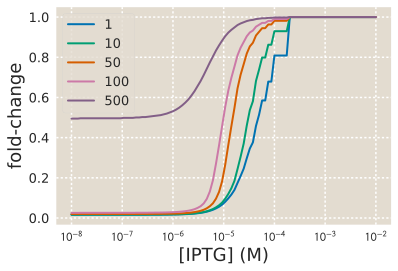

In [4]:
K_A = 139E-6
K_I = 0.53E-6
e_AI = 4.5
R = 260
Op = -13.9
IPTG = np.logspace(-8, -2, 100)
N_vals = [1, 10, 50, 100, 500]

#plt.plot(IPTG, fold_change(IPTG, K_A, K_I, e_AI, R, Op), label = 1)
for i, N in enumerate(N_vals):
    fc = fold_change_var_N(IPTG, K_A, K_I, R, e_AI, N, Op)
    plt.plot(IPTG, fc, color=colors[i], label=N)
plt.xscale('log')
plt.legend()
plt.xlabel('[IPTG] (M)')
plt.ylabel('fold-change')
#plt.yscale('log')

plt.savefig('multiple_copies_titration_discrete.pdf', bbox_inches='tight')

## Fugacity Strategy

As we can see, the summation strategy is non-ideal for a few reasons. First, the expression for fold-change is complex. Due to the large factorials in the expression, it is prone to overflow problems. Additionally, another analytical expression must be derived for any change in the system, for example adding competitor binding sites. Finally, jagged plots are an unattractive artifact of summations that obscure the true y values at certain values of x. We can circumvent all of these issues by using an expression that accounts for the repressors' fugacity, as detailed in Weinert \textit{et al.} 2014, Scaling of Gene Expression with Transcription-Factor Fugacity. 

In [5]:
def fugacity(IPTG, R, Ns, e_s, K_A=139E-6, K_I=0.53E-6, e_AI=4.5, Nc=0, e_c=0):
    '''
    Solves for the fugacity of simple repression with 
    multiple promoter copies (Ns, with energy e_s) or competitor sites
    (Nc, with energy e_c).
    Parameters
    ----------
    R : float
        Number of repressors per cell
    e_AI : float
        Energetic difference between the active and inactive state
    Ns : float
        Number of specific operators available for repressor binding
    Nc : float
        Number of competitor operators available for repressor binding
    e_s : float
        Binding energy between specific operator and repressor as inferred in Garcia 2011
    e_c : float
        Binding energy between competitor operator and repressor
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    Returns
    -------
    fugacity at each IPTG concentration
    '''
    NNS = 4.6E6
    lam = []
    func = lambda x: -Reff + Ns*(x * np.exp(-e_s))/(1 + x * np.exp(-e_s)) +\
                         NNS * (x)/(1 + x) + \
                         Nc*(x * np.exp(-e_c))/(1 + x * np.exp(-e_c))
    for c in IPTG:
        Reff = R * pact(c, K_A, K_I, e_AI)
        lam.append(fsolve(func, 0))
    return np.array(lam)

def occupancy(lam, e_s):
    '''
    Computes fold-change for simple repression using the fugacity (lam).
    Parameters
    ----------
    lam : float
        fugacity of system as calculated by fugacity()
    e_s : float
        binding energy of specific operator
    Returns
    -------
    fold-change (occupancy)
    '''
    return 1/(1 + lam * np.exp(-(e_s)))

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


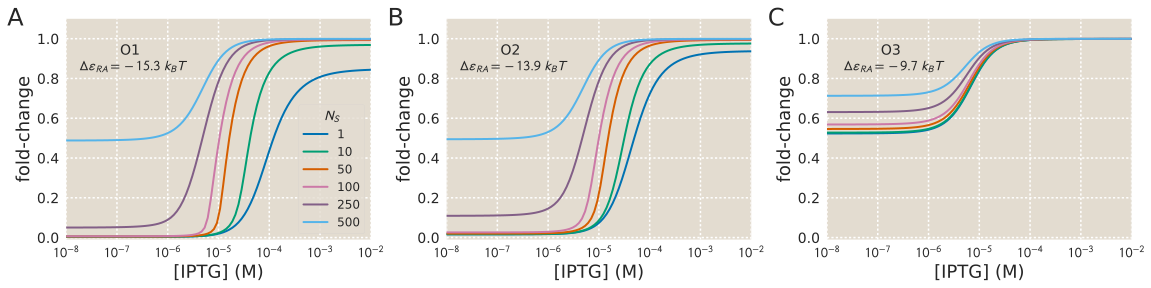

In [6]:
# Plot rows separately for ease of use in writeup

ops = [-15.3, -13.9, -9.7]
op_names = ['O1', 'O2', 'O3']
fig_labels = ['A', 'B', 'C']
Ns = [1, 10, 50, 100, 250, 500]
IPTG = np.logspace(-8, -2, 100)
R=260

fig, ax = plt.subplots(ncols=3,  sharey=False, figsize=(16, 4))

for i, a in enumerate(ax):
    for N in Ns:
        lam_array = fugacity(IPTG, R, Ns=N, e_s=ops[i])
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=N)
    a.set_xscale('log')
    a.set_ylabel('fold-change')
    a.set_ylim(-0.01,1.1)
    a.set_xlim(1E-8, 1E-2)
    a.set_xlabel('[IPTG] (M)')
    a.tick_params(labelsize=14)
    
    a.text(2E-7, 0.9, '%s \n' % op_names[i] + r'$\Delta \varepsilon_{RA}= %0.1f\ k_BT$' % ops[i],\
           ha='center', va='center', fontsize=14)
    a.text(1E-9, 1.1, fig_labels[i], ha='center', va='center', fontsize=24)

leg1 = ax[0].legend(title=r'$N_S$', fontsize=12, loc='lower right')
leg1.get_title().set_fontsize(14)


plt.tight_layout()
plt.savefig('fugacity_Ns.pdf', bbox_inches='tight')

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


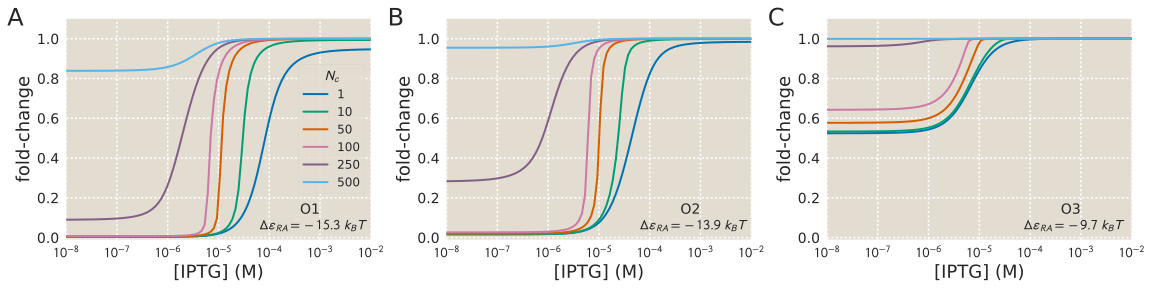

In [7]:
ops = [-15.3, -13.9, -9.7]
op_names = ['O1', 'O2', 'O3']
fig_labels = ['A', 'B', 'C']
reps = [1740, 1220, 260, 124, 60, 22]
Nc = [1, 10, 50, 100, 250, 500]
Ns = [1]
IPTG = np.logspace(-8, -2, 100)
R=260
e_c = -17.0

fig, ax = plt.subplots(ncols=3,  sharey=False, figsize=(16, 4))

for i, a in enumerate(ax):
    for N in Nc:
        lam_array = fugacity(IPTG, R, Ns=1, e_s=ops[i], Nc=N, e_c=e_c)
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=N)
    a.set_xscale('log')
    a.set_ylabel('fold-change')
    a.set_xlabel('[IPTG] (M)')
    a.set_ylim(-0.01,1.1)
    a.set_xlim(1E-8, 1E-2)
    a.tick_params(labelsize=14)
    
    a.text(7E-4, 0.1, '%s \n' % op_names[i] + r'$\Delta \varepsilon_{RA}= %0.1f\ k_BT$' % ops[i],\
           ha='center', va='center', fontsize=14)
    a.text(1E-9, 1.1, fig_labels[i], ha='center', va='center', fontsize=24)

leg1 = ax[0].legend(title=r'$N_c$', fontsize=12, loc='center right')
leg1.get_title().set_fontsize(14)

plt.tight_layout()
plt.savefig('fugacity_Nc.pdf', bbox_inches='tight')

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


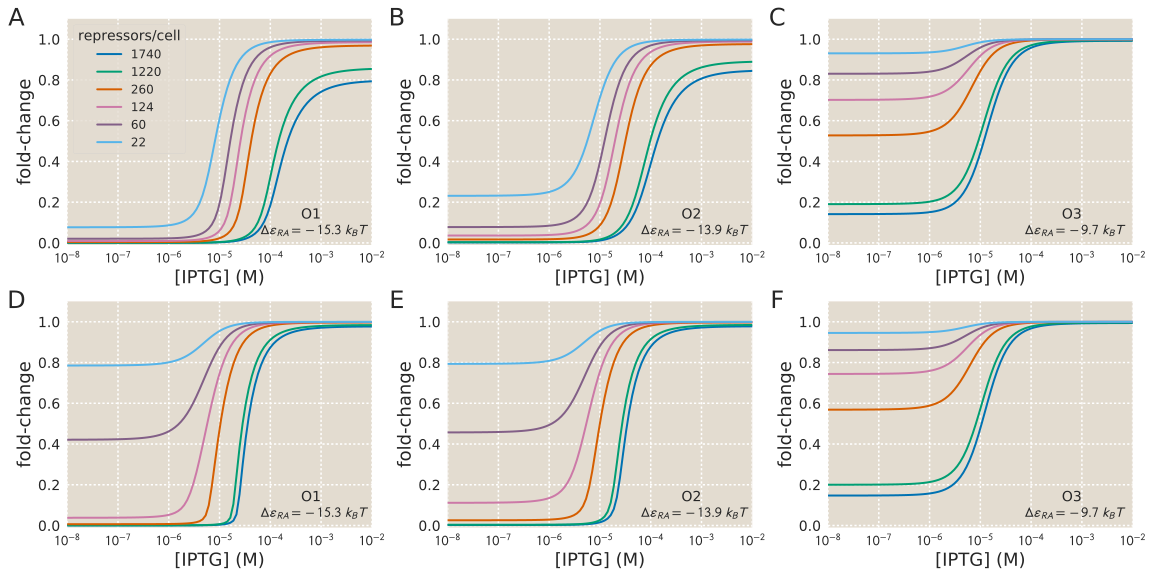

In [8]:
ops = [-15.3, -13.9, -9.7]
op_names = ['O1', 'O2', 'O3']
fig_labels = [['A', 'B', 'C'], ['D', 'E', 'F']]
reps = [1740, 1220, 260, 124, 60, 22]
Ns = [10, 100]
IPTG = np.logspace(-8, -2, 100)

fig, ax = plt.subplots(ncols=3, nrows=2, sharey=False, figsize=(16, 8))

for i, a in enumerate(ax[0]):
    for rep in reps:
        lam_array = fugacity(IPTG, rep, Ns=Ns[0], e_s=ops[i])
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=rep)
    a.set_xscale('log')
    a.set_ylabel('fold-change')
    a.set_xlabel('[IPTG] (M)')
    a.set_ylim(-0.01,1.1)
    a.set_xlim(1E-8, 1E-2)
    a.tick_params(labelsize=14)
    
    a.text(7E-4, 0.1, '%s \n' % op_names[i] + r'$\Delta \varepsilon_{RA}= %0.1f\ k_BT$' % ops[i],\
           ha='center', va='center', fontsize=14)
    a.text(1E-9, 1.1, fig_labels[0][i], ha='center', va='center', fontsize=24)
    
for i, a in enumerate(ax[1]):
    for rep in reps:
        lam_array = fugacity(IPTG, rep, Ns=Ns[1], e_s=ops[i])
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=rep)
    a.set_xscale('log')
    a.set_ylabel('fold-change')
    a.set_xlabel('[IPTG] (M)')
    a.set_ylim(-0.01,1.1)
    a.set_xlim(1E-8, 1E-2)
    a.tick_params(labelsize=14)
    
    a.text(7E-4, 0.1, '%s \n' % op_names[i] + r'$\Delta \varepsilon_{RA}= %0.1f\ k_BT$' % ops[i],\
           ha='center', va='center', fontsize=14)
    a.text(1E-9, 1.1, fig_labels[1][i], ha='center', va='center', fontsize=24)

leg1 = ax[0][0].legend(title='repressors/cell', fontsize=12, loc='upper left')
leg1.get_title().set_fontsize(14)

plt.tight_layout()
plt.savefig('fugacity_R.pdf', bbox_inches='tight')

## Saturation, Leakiness, and Dynamic Range

Since the only aspect of the fugacity expression that depends on IPTG is $p_A(c)$, we can easily modify the expression to give us values for leakiness, saturation, and dynamic range. We only need to note that 

\begin{equation}
p_A(0) = \frac{1}{1 + e^{-\beta \Delta \varepsilon_{AI}}}
\end{equation}

and 

\begin{equation}
p_A(c \rightarrow \infty) = \frac{1}{1 + e^{-\beta \Delta \varepsilon_{AI}} \left( \frac{K_A}{K_I} \right)^n}.
\end{equation}


In [9]:
def fugacity_leakiness(R, Ns, e_s, e_AI=4.5, Nc=0, e_c=0):
    '''
    Solves for the leakiness of a simple repression construct with 
    multiple promoter copies (Ns, with energy e_s) or competitor sites
    (Nc, with energy e_c).
    Parameters
    ----------
    R : float
        Number of repressors per cell
    e_AI : float
        Energetic difference between the active and inactive state
    Ns : float
        Number of specific operators available for repressor binding
    Nc : float
        Number of competitor operators available for repressor binding
    e_s : float
        Binding energy between specific operator and repressor as inferred in Garcia 2011
    e_c : float
        Binding energy between competitor operator and repressor
    e_AI : float
        Energetic difference between the active and inactive state
    Returns
    -------
    leakiness
    '''
    NNS = 4.6E6
    p_A = 1/(1 + np.exp(-e_AI))
    Reff = R * p_A
    leakiness = []
    for R in R:
        Reff = R * p_A
        func = lambda x: -Reff + Ns*(x * np.exp(-e_s))/(1 + x * np.exp(-e_s)) +\
                             NNS * (x)/(1 + x) + \
                             Nc*(x * np.exp(-e_c))/(1 + x * np.exp(-e_c))
        lam = fsolve(func, 0)
        leakiness.append(1/(1 + lam * np.exp(-(e_s))))
    return np.array(leakiness)

def fugacity_saturation(R, Ns, e_s, K_A=139E-6, K_I=0.53E-6, e_AI=4.5, Nc=0, e_c=0):
    '''
    Solves for the saturation of a simple repression construct with 
    multiple promoter copies (Ns, with energy e_s) or competitor sites
    (Nc, with energy e_c).
    Parameters
    ----------
    R : float
        Number of repressors per cell
    e_AI : float
        Energetic difference between the active and inactive state
    Ns : float
        Number of specific operators available for repressor binding
    Nc : float
        Number of competitor operators available for repressor binding
    e_s : float
        Binding energy between specific operator and repressor as inferred in Garcia 2011
    e_c : float
        Binding energy between competitor operator and repressor
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    Returns
    -------
    saturation
    '''
    NNS = 4.6E6
    p_A = 1/(1 + np.exp(-e_AI) * (K_A/K_I)**2)
    saturation = []
    for R in R:
        Reff = R * p_A
        func = lambda x: -Reff + Ns*(x * np.exp(-e_s))/(1 + x * np.exp(-e_s)) +\
                             NNS * (x)/(1 + x) + \
                             Nc*(x * np.exp(-e_c))/(1 + x * np.exp(-e_c))
        lam = fsolve(func, 0)
        saturation.append(1/(1 + lam * np.exp(-(e_s))))
    return np.array(saturation)

def fugacity_dynamic_range(R, Ns, e_s, K_A=139E-6, K_I=0.53E-6, e_AI=4.5, Nc=0, e_c=0):
    '''
    Solves for the dynamic range of a simple repression construct with 
    multiple promoter copies (Ns, with energy e_s) or competitor sites
    (Nc, with energy e_c).
    Parameters
    ----------
    R : float
        Number of repressors per cell
    e_AI : float
        Energetic difference between the active and inactive state
    Ns : float
        Number of specific operators available for repressor binding
    Nc : float
        Number of competitor operators available for repressor binding
    e_s : float
        Binding energy between specific operator and repressor as inferred in Garcia 2011
    e_c : float
        Binding energy between competitor operator and repressor
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    Returns
    -------
    dynamic range
    '''
    return fugacity_saturation(R, Ns, e_s, K_A, K_I, e_AI, Nc, e_c) -\
           fugacity_leakiness(R, Ns, e_s, e_AI, Nc, e_c)

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


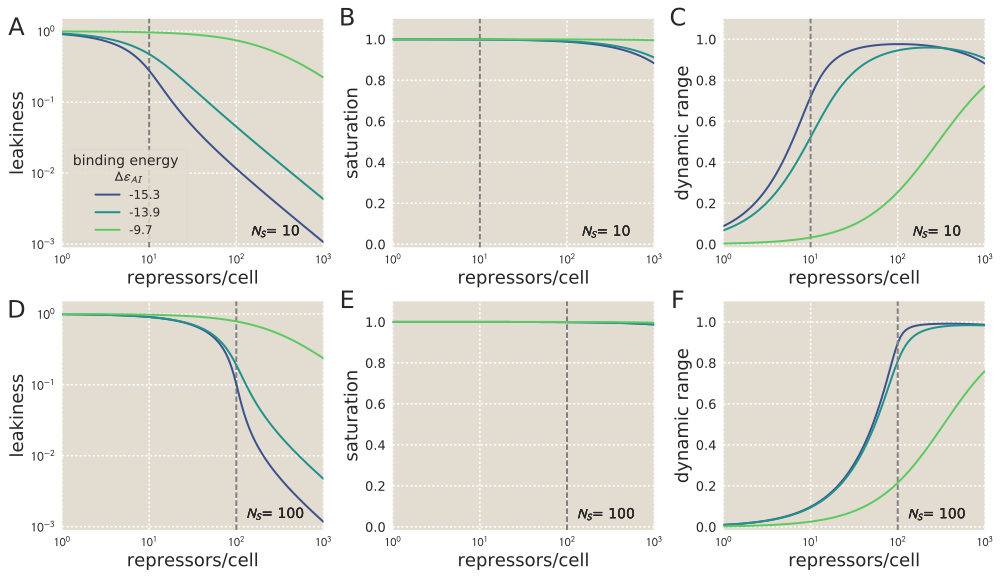

In [10]:
# Start with variable Ns

ops = [-15.3, -13.9, -9.7]
op_names = ['O1', 'O2', 'O3']
fig_labels = [['A', 'B', 'C'], ['D', 'E', 'F']]
y_labels = ['leakiness', 'saturation', 'dynamic range']
reps = np.logspace(0, 3, 100)
Ns = [10, 100, 500]

op_colors = sns.color_palette('viridis', n_colors=len(ops))

fig, ax = plt.subplots(ncols=3, nrows=2, sharey=False, figsize=(14, 8))

for i, a in enumerate(ax):
    for j, op in enumerate(ops):
        # Produce plots
        a[j].axvline(Ns[i], ls='--', color='gray')
        a[0].plot(reps, fugacity_leakiness(reps, Ns[i], op), color=op_colors[j], label=ops[j])
        
        a[1].plot(reps, fugacity_saturation(reps, Ns[i], op), color=op_colors[j])
        
        a[2].plot(reps, fugacity_dynamic_range(reps, Ns[i], op), color=op_colors[j])
        
        # Format axes
        a[0].set_yscale('log')
        a[j].set_xscale('log')
        a[j].set_xlabel('repressors/cell')
        a[j].set_ylabel(y_labels[j])
        a[j].set_xlim(1E0, 1E3)
        
        a[0].set_ylim(9E-4, 1.5E0)
        a[1].set_ylim(-0.015, 1.1)
        a[2].set_ylim(-0.015, 1.1)
        
        # Add figure text
        a[0].text(2.8E2, 1.5E-3, r'$N_S$= %s' % str(Ns[i]),\
           ha='center', va='center', fontsize=14)
        a[1].text(2.8E2, 0.06, r'$N_S$= %s' % str(Ns[i]),\
           ha='center', va='center', fontsize=14)
        a[2].text(2.8E2, 0.06, r'$N_S$= %s' % str(Ns[i]),\
           ha='center', va='center', fontsize=14)
        a[j].text(3E-1, 1.1, fig_labels[i][j], ha='center', va='center', fontsize=24)
        
# Add legend
leg = ax[0][0].legend(title='binding energy \n' + r'$\Delta \varepsilon_{AI}$',\
                      fontsize=12, loc='lower left')
plt.setp(leg.get_title(), multialignment='center')
leg.get_title().set_fontsize(14)

plt.tight_layout()
plt.savefig('fugacity_properties_Ns.pdf', bbox_inches='tight')

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


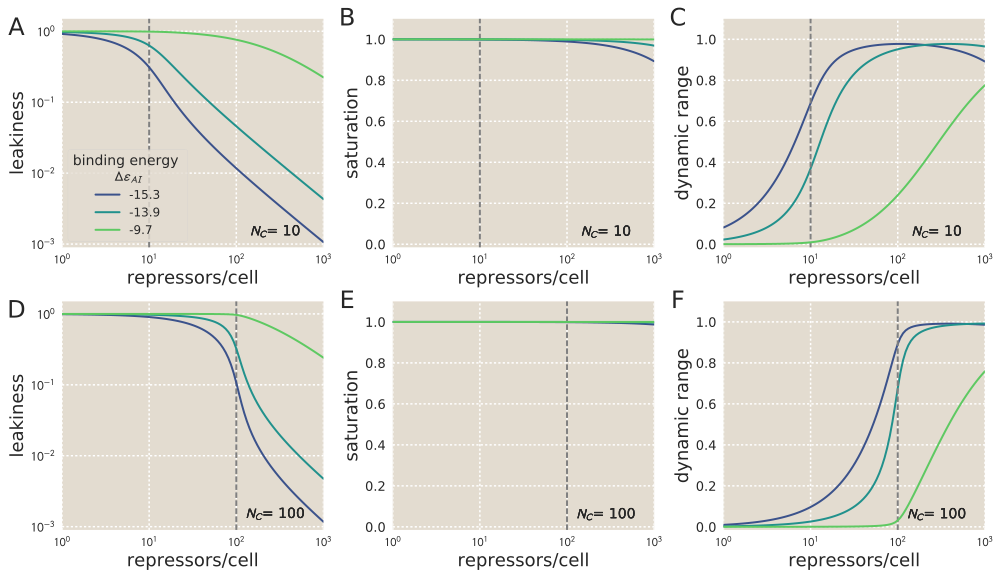

In [11]:
# Now look at variable Nc

ops = [-15.3, -13.9, -9.7]
op_names = ['O1', 'O2', 'O3']
fig_labels = [['A', 'B', 'C'], ['D', 'E', 'F']]
y_labels = ['leakiness', 'saturation', 'dynamic range']
reps = np.logspace(0, 3, 100)
Nc = [10, 100]
e_c = -15.3

op_colors = sns.color_palette('viridis', n_colors=len(ops))

fig, ax = plt.subplots(ncols=3, nrows=2, sharey=False, figsize=(14, 8))

for i, a in enumerate(ax):
    for j, op in enumerate(ops):
        # Produce plots
        a[j].axvline(Ns[i], ls='--', color='gray')
        a[0].plot(reps, fugacity_leakiness(reps, 1, op, Nc=Nc[i], e_c=e_c), color=op_colors[j], label=ops[j])
        
        a[1].plot(reps, fugacity_saturation(reps, 1, op, Nc=Nc[i], e_c=e_c), color=op_colors[j])
        
        a[2].plot(reps, fugacity_dynamic_range(reps, 1, op, Nc=Nc[i], e_c=e_c), color=op_colors[j])
        
        # Format axes
        a[0].set_yscale('log')
        a[j].set_xscale('log')
        a[j].set_xlabel('repressors/cell')
        a[j].set_ylabel(y_labels[j])
        a[j].set_xlim(1E0, 1E3)
        
        a[0].set_ylim(9E-4, 1.5E0)
        a[1].set_ylim(-0.015, 1.1)
        a[2].set_ylim(-0.015, 1.1)

# Add figure text
        a[0].text(2.8E2, 1.5E-3, r'$N_C$= %s' % str(Nc[i]),\
           ha='center', va='center', fontsize=14)
        a[1].text(2.8E2, 0.06, r'$N_C$= %s' % str(Nc[i]),\
               ha='center', va='center', fontsize=14)
        a[2].text(2.8E2, 0.06, r'$N_C$= %s' % str(Nc[i]),\
           ha='center', va='center', fontsize=14)
        a[j].text(3E-1, 1.1, fig_labels[i][j], ha='center', va='center', fontsize=24)
        
# Add legend
leg = ax[0][0].legend(title='binding energy \n' + r'$\Delta \varepsilon_{AI}$',\
                      fontsize=12, loc='lower left')
plt.setp(leg.get_title(), multialignment='center')
leg.get_title().set_fontsize(14)

plt.tight_layout()
#plt.savefig('fugacity_properties_Nc.pdf', bbox_inches='tight')

### 9-panel figure for rebuttal

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


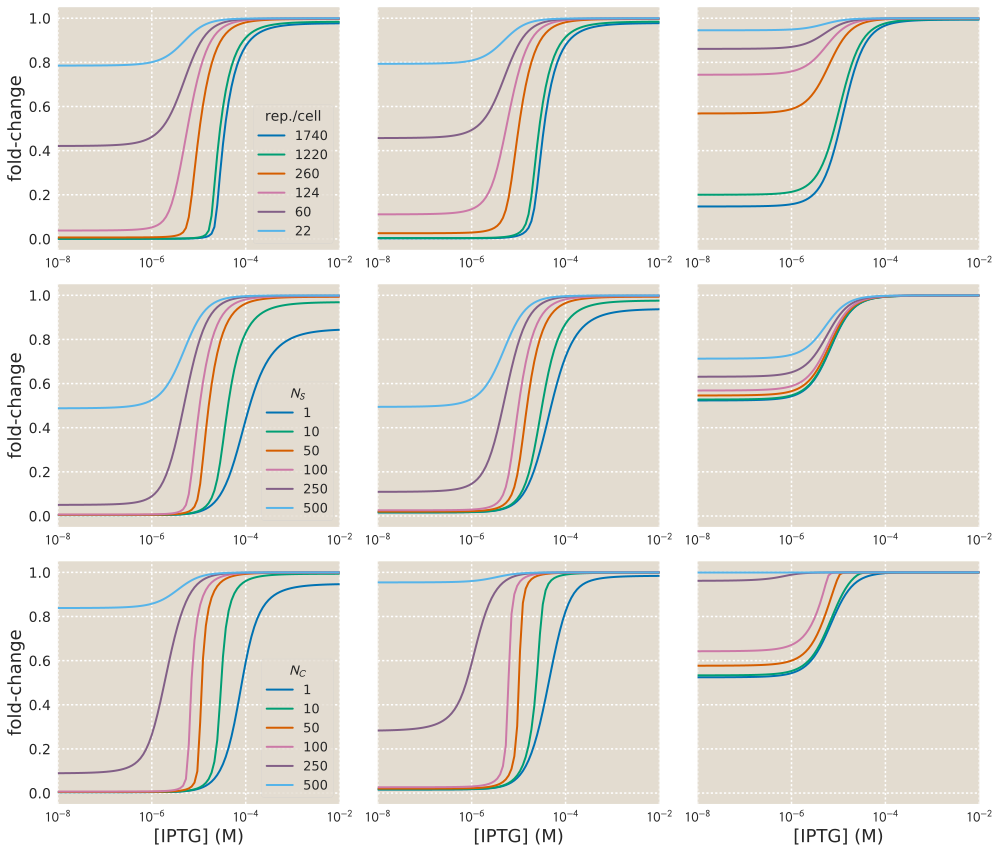

In [28]:
ops = [-15.3, -13.9, -9.7]
op_names = ['O1', 'O2', 'O3']
reps = [1740, 1220, 260, 124, 60, 22]
Nc = [1, 10, 50, 100, 250, 500]
Ns = [1, 10, 50, 100, 250, 500]
IPTG = np.logspace(-8, -2, 100)
e_c = -17.0

fig, ax = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(14, 12))

for i, a in enumerate(ax[0]):
    for rep in reps:
        lam_array = fugacity(IPTG, rep, Ns=100, e_s=ops[i])
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=rep)
        a.set_xlim(1E-8, 1E-2)
        a.set_xscale('log')
        a.tick_params(labelsize=14)
ax[0][0].set_ylabel('fold-change')
leg1 = ax[0][0].legend(title='rep./cell', loc='lower right')
leg1.get_title().set_fontsize(14)

for i, a in enumerate(ax[1]):
    for N in Ns:
        lam_array = fugacity(IPTG, R=260, Ns=N, e_s=ops[i])
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=N)
        a.set_xlim(1E-8, 1E-2)
        a.set_xscale('log')
        a.tick_params(labelsize=14)
ax[1][0].set_ylabel('fold-change')
leg2 = ax[1][0].legend(title=r'$N_S$', loc='lower right')
leg2.get_title().set_fontsize(14)

for i, a in enumerate(ax[2]):
    for N in Nc:
        lam_array = fugacity(IPTG, R, Ns=1, e_s=ops[i], Nc=N, e_c=e_c)
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=N)
        a.set_xlim(1E-8, 1E-2)
        a.set_xscale('log')
        a.tick_params(labelsize=14)
        a.set_xlabel('[IPTG] (M)')
ax[2][0].set_ylabel('fold-change')
leg3 = ax[2][0].legend(title=r'$N_C$', loc='lower right')
leg3.get_title().set_fontsize(14)

plt.tight_layout()